> __Purpose:__ This NB visualizes the results of the full study for DynamicMomonaNet. Will be adding different feature engineerings here.

In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42) 

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import *  # Replace?
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj


In [2]:
MODEL_STR = "DynamicMomonaNet"
MY_CONFIG = DynamicMomonaNet_config
SAVE_FIGS = False
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Train/test user split: 24/8
## Is this part of config now? The split number?
## No it is hardcoded below...



In [3]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P102,pan,1,"[[-1.5563754649803136, -0.17884213655174025, -...",5,6
1,P102,pan,2,"[[-2.0947934429427453, -0.18463052523258242, -...",5,6
2,P102,pan,3,"[[-1.47972105766918, -0.14489860670069354, -0....",5,6
3,P102,pan,4,"[[-1.4504054170702374, -0.18478424991674858, -...",5,6
4,P102,pan,5,"[[-1.809093742221055, -0.21738573258562152, -0...",5,6


In [4]:
import json
# Load the fixed user splits
with open("24_8_user_splits.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]


In [5]:
# Prepare data
data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [6]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
# TODO: Pull this from other file
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [7]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [8]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[-0.6972903868887379, -0.1438853751620267, -2....",0,P132,23
1,"[-0.746909888443831, -0.15534053862491254, -2....",0,P132,23
2,"[-0.864700149729784, -0.08288601842218798, -2....",0,P132,23
3,"[-0.9042468983044636, -0.258261403844061, -3.1...",0,P132,23
4,"[-0.6543603503854262, -0.13391364519529084, -2...",0,P132,23


In [9]:
# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\results\\clustering_models\\20250210_2137\\20250210_2137_DynamicMomonaNet_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


# Finetuning Process

In [10]:
# This needs to be formalized... ie how we pick which iter to use for the cutpoint

cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)

Cluster list:
[31, 35, 38, 39, 40, 41]


In [11]:
full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\ELEC573_Proj\\models\\20250211_2010", 'pretrained_DynamicMomonaNet_model.pth')

print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = select_model(MODEL_STR, MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path))

Full Path: C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\models\20250211_2010\pretrained_DynamicMomonaNet_model.pth


<All keys matched successfully>

In [12]:
cluster_lst = list(nested_clus_model_dict['Iter18'].keys())
print("Cluster list:")
print(cluster_lst)

Cluster list:
[31, 35, 38, 39, 40, 41]


In [13]:
# Prepare data
one_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=1, finetuning_trials_per_gesture=1,
)

three_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=3, finetuning_trials_per_gesture=3,
)

five_trial_data_splits = prepare_data(
    expdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=5, finetuning_trials_per_gesture=5,
)

In [14]:
#novel_participant_ft_data = finetuning_datasplits['novel_trainFT']
#novel_participant_test_data = finetuning_datasplits['cross_subject_test']
#novel_pids = np.unique(finetuning_datasplits['novel_trainFT']['participant_ids'])
#novel_pid_clus_asgn_data = cluster_assgnmt_data_splits['novel_trainFT']

np.unique(three_trial_data_splits['novel_trainFT']['participant_ids'])

array(['P010', 'P102', 'P104', 'P108', 'P121', 'P123', 'P124', 'P128'],
      dtype='<U4')

## ONE-SHOT: 1 trial for training (local+FT) and cluster assignment

In [15]:
data_dict_1_1 = full_comparison_run(one_trial_data_splits, one_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P010, 0/8
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.3)
Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.
PID P102, 1/8
Epoch 00030: reducing learning rate of group 0 to 1.0000e-03.
Cluster 38 had the highest accuracy (0.3)
Epoch 00013: reducing learning rate of group 0 to 1.0000e-03.
PID P104, 2/8
Epoch 00036: reducing learning rate of group 0 to 1.0000e-03.
Cluster 31 had the highest accuracy (0.1)
Epoch 00033: reducing learning rate of group 0 to 1.0000e-03.
PID P108, 3/8
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
Cluster 40 had the highest accuracy (0.7)
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
PID P121, 4/8
Epoch 00030: reducing learning rate of group 0 to 1.0000e-03.
Cluster 31 had the highest accuracy (0.2)
Epoch 00029: reducing learning rate of group 0 to 1.0000e-03.
PID P123, 5/8
Epoch 00034: reducing learning rate of group 0 to 1.0000e-03.
Cluster 39 had the highe

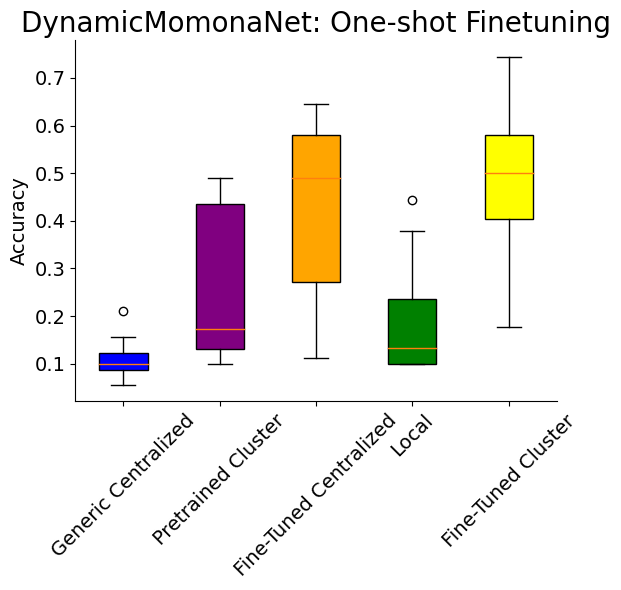

In [16]:
plot_model_acc_boxplots(data_dict_1_1, my_title=f"{MODEL_STR}: One-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT")

## FEW-SHOT: 5 trials for training (local+FT) and 5 trials for cluster assignment

In [17]:
data_dict_5_5 = full_comparison_run(five_trial_data_splits, five_trial_data_splits, MY_CONFIG, pretrained_generic_model,
                        nested_clus_model_dict, MODEL_STR, cluster_iter_str='Iter18')

PID P010, 0/8
Epoch 00027: reducing learning rate of group 0 to 1.0000e-03.
Cluster 39 had the highest accuracy (0.18)
Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
PID P102, 1/8
Cluster 38 had the highest accuracy (0.72)
Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.
PID P104, 2/8
Cluster 40 had the highest accuracy (0.18)
Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.
PID P108, 3/8
Epoch 00025: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.
Cluster 40 had the highest accuracy (0.2)
Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.
PID P121, 4/8
Epoch 00032: reducing learning rate of group 0 to 1.0000e-03.
Cluster 35 had the highest accuracy (0.18)
Epoch 00020: reducing learning rate of group 0 to 1.0000e-03.
PID P123, 5/8
Cluster 38 had the h

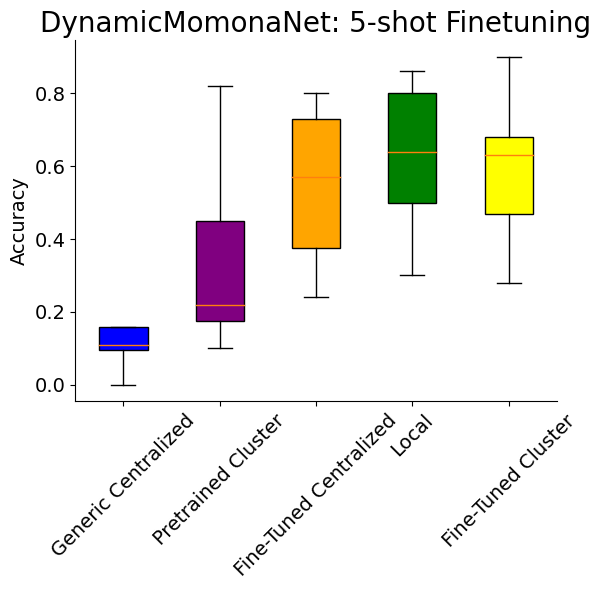

In [18]:
plot_model_acc_boxplots(data_dict_5_5, my_title=f"{MODEL_STR}: 5-shot Finetuning", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_5TA_5TT")
